<a href="https://colab.research.google.com/github/Salvoaf/BreastCancerClassification/blob/main/0.%20AnalyzeDataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Download dataset

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle (1).json


{'kaggle.json': b'{"username":"salvoaranciofebbo","key":"9e7080e0c1780b6ea2eecc3b0c74f79c"}'}

In [ ]:
!pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import os
os.makedirs(os.path.expanduser("~/.kaggle"), exist_ok=True)

In [ ]:
!cp kaggle.json ~/.kaggle/

In [ ]:
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d paultimothymooney/breast-histopathology-images

100% 3.09G/3.10G [00:25<00:00, 137MB/s]
100% 3.10G/3.10G [00:25<00:00, 130MB/s]


In [ ]:
!unzip breast-histopathology-images.zip

#Let's investigate the structure of the dataset

**Loading packages and setting**

In [ ]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau, StepLR, CyclicLR
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.utils.class_weight import compute_class_weight


from glob import glob
from skimage.io import imread
from os import listdir

import time
import copy
from tqdm import tqdm_notebook as tqdm

In [ ]:
run_training = False
retrain = False
find_learning_rate = False

**Exploring the data structure**

**How many patients do we have?**

In [ ]:
base_path = "../content/IDC_regular_ps50_idx5/"
folder = listdir(base_path)
len(folder)


279

**How many patches do we have in total?**

In [ ]:
total_patches = 0
for patches_each_patient in folder:
  path_patient = base_path +"/"+ patches_each_patient  #"../content/IDC_regular_ps50_idx5/id_patient"
  classes = listdir(path_patient)
  for c in classes:
    path_patient_class = path_patient +"/"+ c   #"../content/IDC_regular_ps50_idx5/id_patient/class0-1"
    total_patches = total_patches + len(listdir(path_patient_class))

  


In [ ]:
print(f"Total patches: {total_patches}")

Total patches: 277524


**Storing the image_path, patient_id and the target**

In [ ]:
data = pd.DataFrame(index=np.arange(0, total_patches), columns=["patient_id", "path", "target"])
k = 0
for patches_each_patient in folder:
  path_patient = base_path + patches_each_patient  #"../content/IDC_regular_ps50_idx5/id_patient"
  classes = listdir(path_patient)
  for c in classes:
    path_patient_class = path_patient +"/"+ c   #"../content/IDC_regular_ps50_idx5/id_patient/class0-1"
    list_patches = listdir(path_patient_class)
    for name_patch in list_patches:
      data.iloc[k]["path"] = path_patient_class + name_patch
      data.iloc[k]["target"] = c
      data.iloc[k]["patient_id"] = patches_each_patient
      k += 1

data.head()


,patient_id,path,target
0,15473,../content/IDC_regular_ps50_idx5/15473/015473_...,0
1,15473,../content/IDC_regular_ps50_idx5/15473/015473_...,0
2,15473,../content/IDC_regular_ps50_idx5/15473/015473_...,0
3,15473,../content/IDC_regular_ps50_idx5/15473/015473_...,0
4,15473,../content/IDC_regular_ps50_idx5/15473/015473_...,0


In [ ]:
data.shape

(277524, 3)

#Let's analyze what we have extracted

In [ ]:
#Calculating the percentage of IDC present in each image
cancer_perc = data.groupby("patient_id").target.value_counts()/ data.groupby("patient_id").size() #totale patches di singolo target/ totale patches di entrambi i target
cancer_perc = cancer_perc.unstack()
cancer_perc

target,0,1
patient_id,,
10253,0.872495,0.127505
10254,0.910377,0.089623
10255,0.665441,0.334559
10256,0.750000,0.250000
10257,0.672441,0.327559
...,...,...
9346,0.465834,0.534166
9347,0.875610,0.124390
9381,0.903469,0.096531


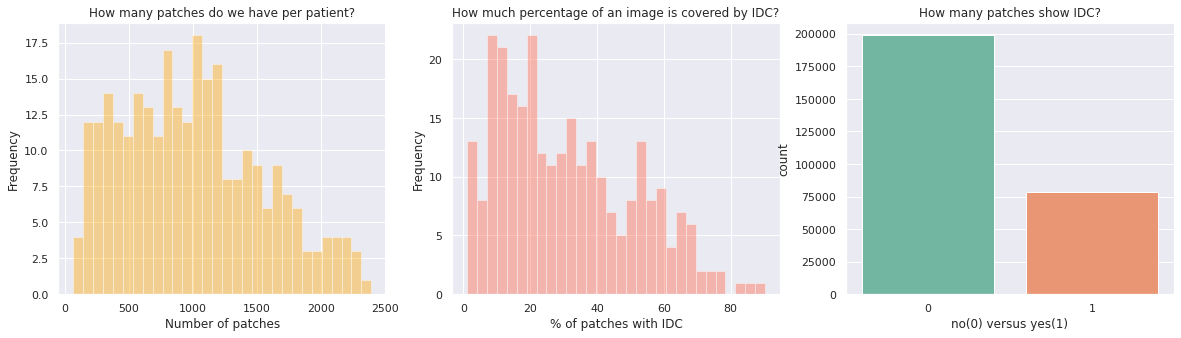

In [ ]:
#Plotting the distribution of number of patches per patient
fig, ax = plt.subplots(1,3,figsize=(20,5))
sns.distplot(data.groupby("patient_id").size(), ax=ax[0], color="Orange", kde=False, bins=30)
ax[0].set_xlabel("Number of patches")
ax[0].set_ylabel("Frequency")
ax[0].set_title("How many patches do we have per patient?")

#Plotting the distribution of IDC percentage per patient
sns.distplot(cancer_perc.loc[:,"1"]*100, ax=ax[1], color="Tomato", kde=False, bins=30)
ax[1].set_title("How much percentage of an image is covered by IDC?")
ax[1].set_ylabel("Frequency")
ax[1].set_xlabel("% of patches with IDC")

#Plotting the count of patches with IDC and without IDC
sns.countplot(data.target, palette="Set2", ax=ax[2])
ax[2].set_xlabel("no(0) versus yes(1)")
ax[2].set_title("How many patches show IDC?")
plt.show()

#Assembling patches to view the photo
Take only first patient to do an example.

> *Now we will notice that the name of the patch corresponds to the coordinates of it in the photo.*




In [ ]:

path_patient = base_path +"/"+ folder[0]  #"../content/IDC_regular_ps50_idx5/id_patient"
classes = listdir(path_patient)
for c in classes:
  path_patient_class = path_patient +"/"+ c   #"../content/IDC_regular_ps50_idx5/id_patient/class0-1"
  print(listdir(path_patient_class))

['15473_idx5_x2551_y1051_class0.png', '15473_idx5_x1201_y2151_class0.png', '15473_idx5_x3001_y1651_class0.png', '15473_idx5_x2401_y1251_class0.png', '15473_idx5_x2601_y201_class0.png', '15473_idx5_x701_y1601_class0.png', '15473_idx5_x2151_y751_class0.png', '15473_idx5_x3001_y1601_class0.png', '15473_idx5_x701_y551_class0.png', '15473_idx5_x2051_y601_class0.png', '15473_idx5_x1401_y251_class0.png', '15473_idx5_x2751_y1451_class0.png', '15473_idx5_x1951_y451_class0.png', '15473_idx5_x1701_y301_class0.png', '15473_idx5_x3201_y1601_class0.png', '15473_idx5_x1851_y351_class0.png', '15473_idx5_x2101_y301_class0.png', '15473_idx5_x2501_y651_class0.png', '15473_idx5_x1501_y351_class0.png', '15473_idx5_x951_y2101_class0.png', '15473_idx5_x2451_y1051_class0.png', '15473_idx5_x2601_y1101_class0.png', '15473_idx5_x851_y901_class0.png', '15473_idx5_x2401_y901_class0.png', '15473_idx5_x1751_y2251_class0.png', '15473_idx5_x2451_y601_class0.png', '15473_idx5_x651_y1701_class0.png', '15473_idx5_x1051_y

In [ ]:
def extract_coords(df):
    coord = df.path.str.rsplit("_", n=4, expand=True)
    coord = coord.drop([0, 1, 4], axis=1)
    coord = coord.rename({2: "x", 3: "y"}, axis=1)
    coord.loc[:, "x"] = coord.loc[:,"x"].str.replace("x", "", case=False).astype(np.int)
    coord.loc[:, "y"] = coord.loc[:,"y"].str.replace("y", "", case=False).astype(np.int)
    df.loc[:, "x"] = coord.x.values
    df.loc[:, "y"] = coord.y.values
    return df

def get_cancer_dataframe(patient_id, cancer_id):
    path = base_path + patient_id + "/" + cancer_id  #entro nella cartella nonché la classe(cancer_id) del paziente patient_id
    files = listdir(path) # ho tutte le patch
    dataframe = pd.DataFrame(files, columns=["filename"])
    path_names = path + "/" + dataframe.filename.values
    dataframe = dataframe.filename.str.rsplit("_", n=4, expand=True)
    dataframe.loc[:, "target"] = np.int(cancer_id)
    dataframe.loc[:, "path"] = path_names
    dataframe = dataframe.drop([0, 1, 4], axis=1)
    dataframe = dataframe.rename({2: "x", 3: "y"}, axis=1)
    dataframe.loc[:, "x"] = dataframe.loc[:,"x"].str.replace("x", "", case=False).astype(np.int)
    dataframe.loc[:, "y"] = dataframe.loc[:,"y"].str.replace("y", "", case=False).astype(np.int)
    return dataframe

def get_patient_dataframe(patient_id):
    df_0 = get_cancer_dataframe(patient_id, "0")
    df_1 = get_cancer_dataframe(patient_id, "1")
    patient_df = df_0.append(df_1)
    return patient_df

In [ ]:
data.patient_id.values[0]

'15473'

In [ ]:
example = get_patient_dataframe(data.patient_id.values[0])
example.head()

,x,y,target,path
0,2551,1051,0,../content/IDC_regular_ps50_idx5/15473/0/15473...
1,1201,2151,0,../content/IDC_regular_ps50_idx5/15473/0/15473...
2,3001,1651,0,../content/IDC_regular_ps50_idx5/15473/0/15473...
3,2401,1251,0,../content/IDC_regular_ps50_idx5/15473/0/15473...
4,2601,201,0,../content/IDC_regular_ps50_idx5/15473/0/15473...


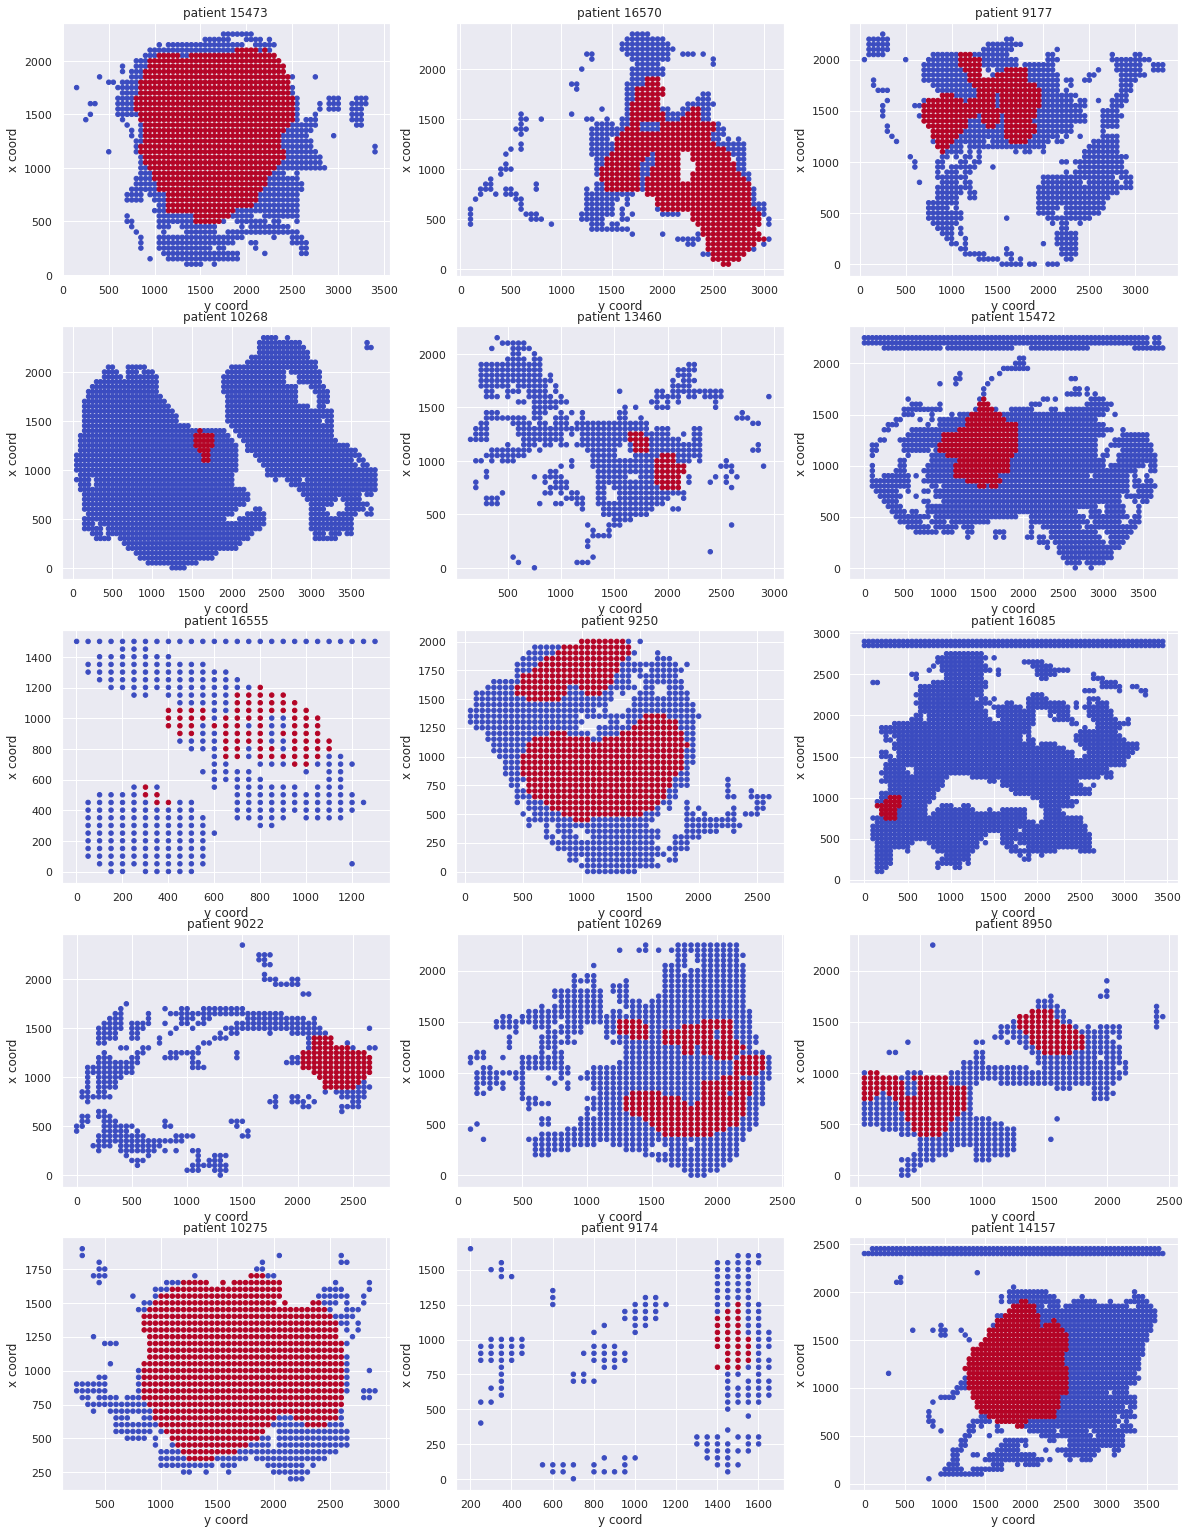

In [ ]:
fig, ax = plt.subplots(5,3,figsize=(20, 27))

patient_ids = data.patient_id.unique()

for n in range(5):
    for m in range(3):
        patient_id = patient_ids[m + 3*n]
        example_df = get_patient_dataframe(patient_id)
        
        ax[n,m].scatter(example_df.x.values, example_df.y.values, c=example_df.target.values, cmap="coolwarm", s=20);
        ax[n,m].set_title("patient " + patient_id)
        ax[n,m].set_xlabel("y coord")
        ax[n,m].set_ylabel("x coord")
